# A trivial example: Titanic dataset
**That scene**. What a tragedy.
But...

![drowning_scene](../fig/drowning_scene.jpg "title-1")

...what if Jane had some machine learning to choose a better partner, more likely to survive in case of accident?

In [1]:
options(warn=-1)
working_dir <- '~' ## If runing locally, replace with the path to the folder in which you saved the notebooks (e.g. 'C:/Documents/mlTeachings') 
setwd(working_dir)

Loading required package: tidyverse
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.2     v dplyr   0.7.4
v tidyr   0.8.0     v stringr 1.3.0
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: caret
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Loading required package: keras
Loading required package: mlbench
Loading required package: ggthemes
Loading required package: assertthat

Attaching package: 'assertthat'

The following object is masked from 'package:tibble':

    has_name

Loading required package: kernlab

Attaching package: 'kernlab'

The following object is masked from 'package:purrr':

    cross

The following object is masked from 'package:ggplot

In [3]:
# import the data
titanic_df = read_csv('data/titanic.csv')

Parsed with column specification:
cols(
  pclass = col_integer(),
  survived = col_integer(),
  name = col_character(),
  sex = col_character(),
  age = col_double(),
  sibsp = col_integer(),
  parch = col_integer(),
  ticket = col_character(),
  fare = col_double(),
  cabin = col_character(),
  embarked = col_character(),
  boat = col_character(),
  body = col_integer(),
  home.dest = col_character()
)


Randomly choosing a partner aged 18 - 40 is **not a good idea, Rose...**

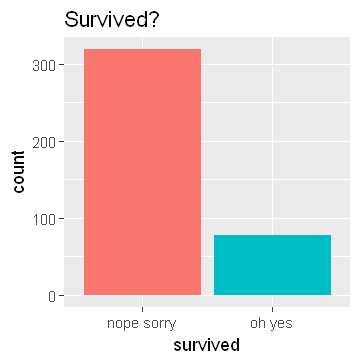

In [4]:
options(repr.plot.width=3, repr.plot.height=3) # reduce plot size

titanic_df %>% filter(sex == 'male', age > 18, age < 40) %>% 
  select(survived) %>% mutate(survived = ifelse(survived == 1, 'oh yes', 'nope sorry')) %>% 
  ggplot(aes(survived, fill = survived)) + geom_bar() + ggtitle('Survived?') + theme(legend.position = "none")

options(repr.plot.width=6, repr.plot.height=5) # back to the normal plot size

...indeed, approximately 3 every 4 will likely die in case of accident.

In [10]:
titanic_df %>% select(
    survived, # select features
    pclass,
    sex,
    age,
    sibsp,
    parch,
    fare,
    cabin,
    embarked) %>% head

titanic_df %>% glimpse

survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
1,1,female,29.0000,0,0,211.3375,B5,S
1,1,male,0.9167,1,2,151.5500,C22 C26,S
0,1,female,2.0000,1,2,151.5500,C22 C26,S
0,1,male,30.0000,1,2,151.5500,C22 C26,S
0,1,female,25.0000,1,2,151.5500,C22 C26,S
1,1,male,48.0000,0,0,26.5500,E12,S


Observations: 1,310
Variables: 14
$ pclass    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ survived  <int> 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, ...
$ name      <chr> "Allen, Miss. Elisabeth Walton", "Allison, Master. Hudson...
$ sex       <chr> "female", "male", "female", "male", "female", "male", "fe...
$ age       <dbl> 29.0000, 0.9167, 2.0000, 30.0000, 25.0000, 48.0000, 63.00...
$ sibsp     <int> 0, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
$ parch     <int> 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...
$ ticket    <chr> "24160", "113781", "113781", "113781", "113781", "19952",...
$ fare      <dbl> 211.3375, 151.5500, 151.5500, 151.5500, 151.5500, 26.5500...
$ cabin     <chr> "B5", "C22 C26", "C22 C26", "C22 C26", "C22 C26", "E12", ...
$ embarked  <chr> "S", "S", "S", "S", "S", "S", "S", "S", "S", "C", "C", "C...
$ boat      <chr> "2", "11", NA, NA, NA, "3", "10", NA, "D", NA, NA, "4", "...
$ body      <int> 

In [12]:
partition = titanic_df %>% nrow %>% seq_len %>% createDataPartition(times = 1, p = 0.7, list = F)

train_raw = titanic_df %>% slice(partition)
test_raw = titanic_df %>% slice(-partition)

cat('train data size\n')
train_raw %>% dim

cat('test data size\n')
test_raw %>% dim

train data size


[1] 918  14

test data size


[1] 392  14

## Prepare the data for being fed into the model
* convert data types to float / integer
* define rule for managing missing values (*NA*s)
* you could even normalize the features (we are not doing this here)

In [13]:
data_processing = function(df){
  df %>%
    select(survived, # select features
           pclass,
           sex,
           age,
           sibsp,
           parch,
           fare,
           cabin,
           embarked
    ) %>% 
    mutate_if(is.character, fct_explicit_na) %>% # assign levels to missings
    mutate_all(as.numeric) %>% mutate_all(funs(replace(., is.na(.), 0))) # %>% # set missings to 0
    # mutate_all(scale) # normalize data
}

train = data_processing(train_raw)
test = data_processing(test_raw)


# save datasets
write_csv(train, 'data/titanic_train.csv')
write_csv(test, 'data/titanic_test.csv')

In [15]:
train %>% glimpse

Observations: 918
Variables: 14
$ pclass    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ survived  <int> 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, ...
$ name      <chr> "Allison, Master. Hudson Trevor", "Allison, Miss. Helen L...
$ sex       <chr> "male", "female", "male", "female", "male", "male", "fema...
$ age       <dbl> 0.9167, 2.0000, 48.0000, 63.0000, 71.0000, 47.0000, 24.00...
$ sibsp     <int> 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, ...
$ parch     <int> 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
$ ticket    <chr> "113781", "113781", "19952", "13502", "PC 17609", "PC 177...
$ fare      <dbl> 151.5500, 151.5500, 26.5500, 77.9583, 49.5042, 227.5250, ...
$ cabin     <chr> "C22 C26", "C22 C26", "E12", "D7", NA, "C62 C64", "B35", ...
$ embarked  <chr> "S", "S", "S", "S", "C", "C", "C", "S", "C", "C", "S", "S...
$ boat      <chr> "11", NA, "3", "10", NA, NA, "9", "6", "6", "A", "5", "5"...
$ body      <int> NA

## Fit a KNN model and make some predictions

In [10]:
# fit knn

model = train(x = train %>% select(-one_of('survived')),
              y = train %>% select(one_of('survived')) %>% pull %>% factor,
              method = 'kknn',
              tuneGrid = data.frame(kmax = 20,
                                    kernel = c("triangular"),
                                    distance = 0.5)
)

# save model

saveRDS(model, 'data/titanic_model.R')

In [11]:
test_response = model %>%
  predict(newdata = test %>% select(-one_of('survived'))) %>% factor

In [12]:
# show predictions for male, aged 18-40

(pred = test_raw %>% bind_cols(data_frame('guess_survived' = test_response)) %>%
  filter(sex == 'male',age > 18, age < 40) %>%
  select(name, sex, age, guess_survived, survived)) %>% head

name,sex,age,guess_survived,survived
"Behr, Mr. Karl Howell",male,26,1,1
"Cardeza, Mr. Thomas Drake Martinez",male,36,1,1
"Carlsson, Mr. Frans Olof",male,33,0,0
"Carter, Mr. William Ernest",male,36,1,1
"Chambers, Mr. Norman Campbell",male,27,1,1
"Clark, Mr. Walter Miller",male,27,0,0


In [13]:
# how good is the model for this subclass?
acc = confusionMatrix(pred$guess_survived, pred$survived %>% factor)
acc$overall[1] %>% round(3)

Accuracy 
   0.804

hey, it seems that now Rose has almost 80% chanche of getting the right partner! Awsome!

## Well, probably not. But why?

Stay tuned...